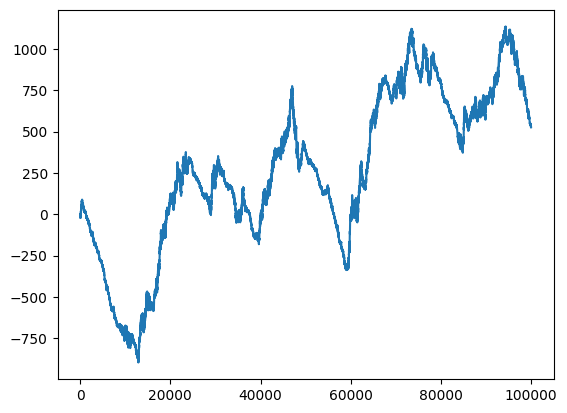

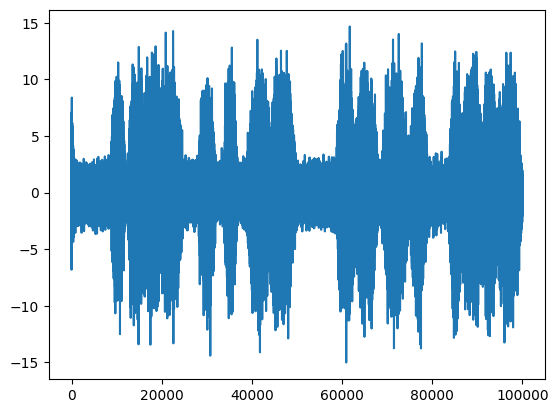

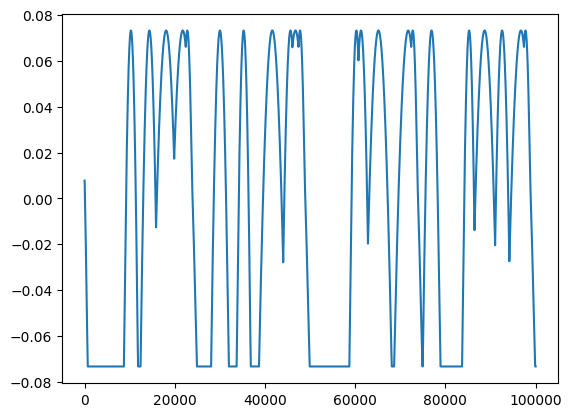

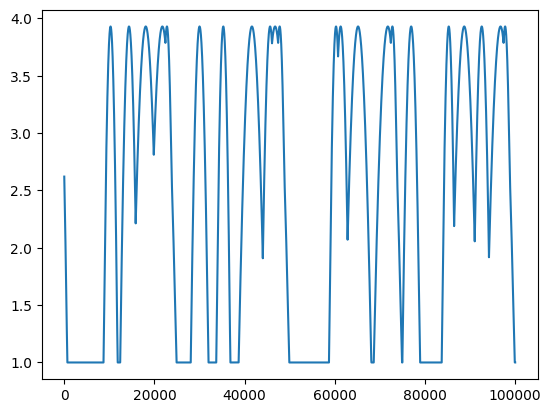

In [1]:
from sem.create_mixture import create_mixture
from sem.sem.normal_mixture_sem import NormalMixtureSEM
import matplotlib.pyplot as plt
import torch
import numpy as np
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
random.seed(seed)



num_components = 5
length = 100000

series, deltas, a_trafaret, b_trafaret = create_mixture(length, num_components)
plt.plot(series)
plt.show()
plt.plot(deltas)
plt.show()
plt.plot(a_trafaret)
plt.show()
plt.plot(b_trafaret)
plt.show()

In [2]:
# (p_k[0] * a_k[0])[component[0]]

In [3]:
sem = NormalMixtureSEM(deltas, 'exp', 'EM', n_components=2, N_init=5, alpha=0.8, exp_smooth=0.6, tol=0.0001, max_iter_sem=1000, device="cpu")
p_k, a_k, b_k, percentiles_t, b_t = sem.find_params()

N = 5; Max ACF(1): 1.0
N = 10; Max ACF(1): 0.9868252277374268
N = 15; Max ACF(1): 0.9665835499763489
N = 20; Max ACF(1): 0.9344454407691956
N = 25; Max ACF(1): 0.8756868839263916
N = 30; Max ACF(1): 0.8565705418586731
N = 35; Max ACF(1): 0.8400590419769287
N = 40; Max ACF(1): 0.8208101987838745
N = 45; Max ACF(1): 0.8117586374282837
N = 50; Max ACF(1): 0.8096222877502441
N = 55; Max ACF(1): 0.8020083904266357
N = 60; Max ACF(1): 0.7788283228874207
Found window length: 60
Batch 0
0 -605456.75
1 -468083.5625
2 -454325.71875
3 -439134.15625
4 -424815.4375
5 -411922.0
6 -400554.875
7 -390425.875
8 -381204.8125
9 -373205.1875
10 -366068.40625
11 -359605.75
12 -353797.0625
13 -348486.25
14 -343520.71875
15 -339064.625
16 -335053.125
17 -331203.625
18 -327712.28125
19 -324498.28125
20 -321535.4375
21 -318736.65625
22 -316085.09375
23 -313666.03125
24 -311412.71875
25 -309317.25
26 -307392.34375
27 -305584.71875
28 -303837.5
29 -302159.625
30 -300703.5625
31 -299423.375
32 -298238.84375
33 -29

In [4]:
component = torch.argmax(p_k, dim=1)

est_deltas = (p_k * a_k)[torch.arange(len(p_k)), component]

In [5]:
x = torch.cumsum(est_deltas, 0)+ series[sem.series_length]

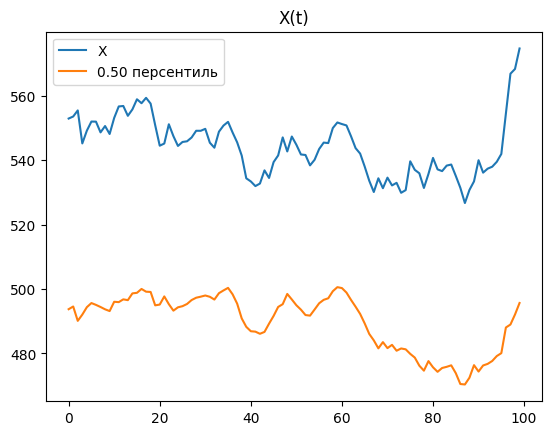

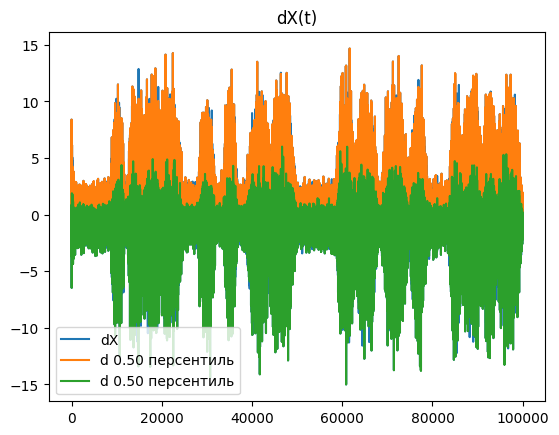

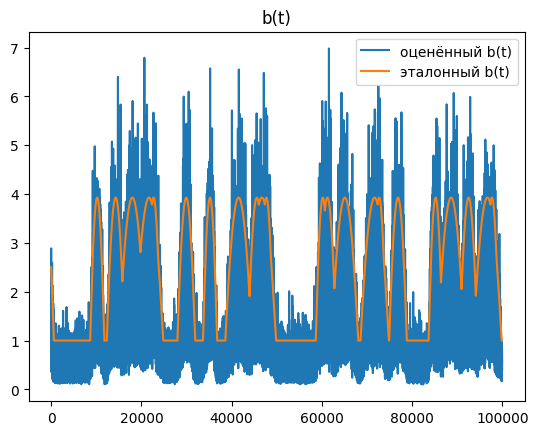

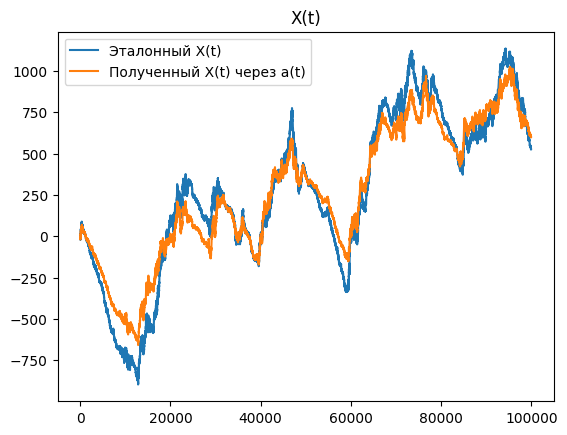

In [6]:
plt.plot(series[sem.series_length-1 + 46_300:sem.series_length-1 + 46_400], label='X')
plt.plot(x[46_300:46_400], label="0.50 персентиль")
plt.legend()
plt.title("X(t)")
plt.show()
plt.plot(deltas[sem.series_length:], label='dX')
plt.plot(a_k.max(1).values, label="d 0.50 персентиль")
plt.plot(a_k.min(1).values, label="d 0.50 персентиль")
plt.legend()
plt.title("dX(t)")
plt.show()
plt.plot(b_t, label="оценённый b(t)")
plt.plot(b_trafaret[sem.series_length-1:], label="эталонный b(t)")
plt.legend()
plt.title("b(t)")
plt.show()
plt.plot(series[sem.series_length:], label="Эталонный X(t)")
plt.plot(x, label="Полученный X(t) через a(t)")
plt.legend()
plt.title("X(t)")
plt.show()

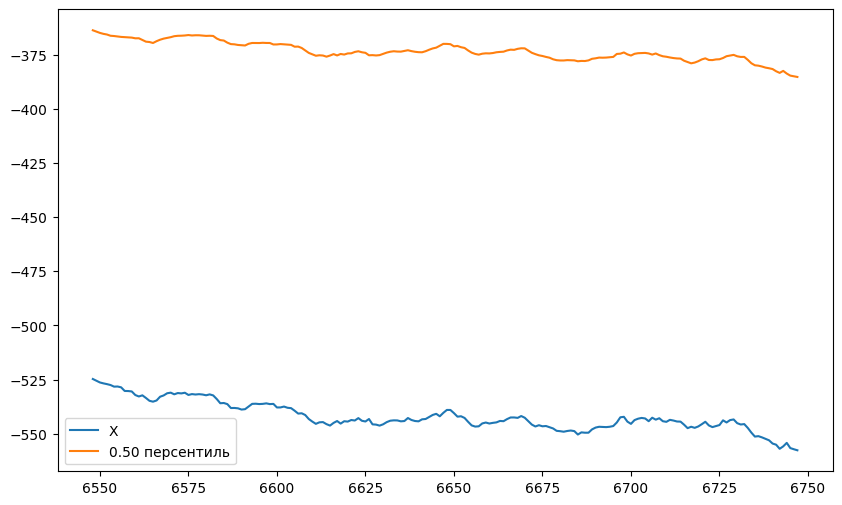

In [ ]:
%matplotlib inline
from IPython.display import clear_output
import matplotlib.pyplot as plt

for i in range(0, 100000 - 200, 4):
    clear_output(wait=True)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(i, i+200), series[sem.series_length-1 + i:sem.series_length-1 + i + 200], label='X')
    plt.plot(range(i, i+200), x[i:i+200], label="0.50 персентиль")
    plt.legend()
    plt.show()